# Comparing Project Gutenberg's 20 Most Popular Books

In this analysis we will use Word2Vec and Doc2Vec to compare Project Gutenberg's 20 most popular books. Word2Vec will be used to show how the relationship between characters can be drawn within, and between books. Doc2Vec will be used to determine which books are most similar. The 20 books that we will use are:
1. A Dolls House by Henrik Ibsen
2. A Tale of Two Cities by Charles Dickens
3. Adventures of Huckleberry Finn by Mark Twain
4. Alices Adventures in Wonderland by Lewis Carroll
5. Dracula by Bram Stoker
6. Emma by Jane Austen
7. Frankenstein by Mary Shelley
8. Great Expectations by Charles Dickens
9. Grimms Fairy Tales by The Brothers Grimm
10. Metamorphosis by Franz Kafka
11. Pride and Prejudice by Jane Austen
12. The Adventures of Sherlock Holmes by Arthur Conan Doyle
13. The Adventures of Tom Sawyer by Mark Twain
14. The Count of Monte Cristo by Alexandre Dumas
15. The Importance of Being Earnest by Oscar Wilde
16. The Picture of Dorian Gray by Oscar Wilde
17. The Prince by Nicolo Machiavelli
18. The Romance of Lust by Anonymous
19. The Yellow Wallpaper by Charlotte Perkins Gilman
20. Ulysses by James Joyce

Further information about Project Gutenberg can be found at http://www.gutenberg.org

In [386]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gensim
%pylab inline

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [385]:
# Create a list of all of our book files.
book_filenames = sorted(glob.glob("*.rtf"))
print("Found books:")
book_filenames

Found books:


['A_Dolls_House_by_Henrik_Ibsen.rtf',
 'A_Tale_of_Two_Cities_by_Charles_Dickens.rtf',
 'Adventures_of_Huckleberry_Finn_by_Mark_Twain.rtf',
 'Alices_Adventures_in_Wonderland_by_Lewis_Carroll.rtf',
 'Dracula_by_Bram_Stoker.rtf',
 'Emma_by_Jane_Austen.rtf',
 'Frankenstein_by_Mary_Shelley.rtf',
 'Great_Expectations_by_Charles_Dickens.rtf',
 'Grimms_Fairy_Tales_by_The_Brothers_Grimm.rtf',
 'Metamorphosis_by_Franz_Kafka.rtf',
 'Pride_and_Prejudice_by_Jane_Austen.rtf',
 'The_Adventures_of_Sherlock_Holmes_by_Arthur_Conan_Doyle.rtf',
 'The_Adventures_of_Tom_Sawyer_by_Mark_Twain.rtf',
 'The_Count_of_Monte_Cristo_by_Alexandre_Dumas.rtf',
 'The_Importance_of_Being_Earnest_by_Oscar_Wilde.rtf',
 'The_Picture_of_Dorian_Gray_by_Oscar_Wilde.rtf',
 'The_Prince_by_Nicolo_Machiavelli.rtf',
 'The_Romance_of_Lust_by_Anonymous.rtf',
 'The_Yellow_Wallpaper_by_Charlotte_Perkins_Gilman.rtf',
 'Ulysses_by_James_Joyce.rtf']

In [4]:
# Read and add the text of each book to corpus_raw.
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'A_Dolls_House_by_Henrik_Ibsen.rtf'...
Corpus is now 165892 characters long

Reading 'A_Tale_of_Two_Cities_by_Charles_Dickens.rtf'...
Corpus is now 980049 characters long

Reading 'Adventures_of_Huckleberry_Finn_by_Mark_Twain.rtf'...
Corpus is now 1561188 characters long

Reading 'Alices_Adventures_in_Wonderland_by_Lewis_Carroll.rtf'...
Corpus is now 1738128 characters long

Reading 'Dracula_by_Bram_Stoker.rtf'...
Corpus is now 2621725 characters long

Reading 'Emma_by_Jane_Austen.rtf'...
Corpus is now 3557407 characters long

Reading 'Frankenstein_by_Mary_Shelley.rtf'...
Corpus is now 4006421 characters long

Reading 'Great_Expectations_by_Charles_Dickens.rtf'...
Corpus is now 5072351 characters long

Reading 'Grimms_Fairy_Tales_by_The_Brothers_Grimm.rtf'...
Corpus is now 5638018 characters long

Reading 'Metamorphosis_by_Franz_Kafka.rtf'...
Corpus is now 5779763 characters long

Reading 'Pride_and_Prejudice_by_Jane_Austen.rtf'...
Corpus is now 6510612 characters long

Reading

In [6]:
# Tokenize each sentence
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(corpus_raw)

In [406]:
def sentence_to_wordlist(raw):
    '''Remove all characters except letters'''
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [8]:
# Clean the raw_sentences and add them to sentences.
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [395]:
# Take a look at a sentence before and after it is cleaned.
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

In the middle of the left-hand wall is a door, and\
beyond it a window.
['In', 'the', 'middle', 'of', 'the', 'left', 'hand', 'wall', 'is', 'a', 'door', 'and', 'beyond', 'it', 'a', 'window']


In [10]:
# Find the total number of tokens in sentences
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 2,493,923 tokens


# Word2Vec

In [397]:
# Set the parameteres for Word2Vec
num_features = 300
min_word_count = 20
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

Note: Using a lower min_word_count could make our work below more accurate, however, TSNE crashes my jupyter notebook when I increase the size of all_word_vectors_matrix (below).

In [435]:
books2vec = w2v.Word2Vec(
    sg=1, #skip-gram
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [436]:
# Build the vocabulary
books2vec.build_vocab(sentences)
print("books2vec vocabulary length:", len(books2vec.vocab))

books2vec vocabulary length: 7462


In [407]:
books2vec.train(sentences)

5282202

In [202]:
# Create a vector matrix of all the words
all_word_vectors_matrix = books2vec.syn0

In [201]:
# Use TSNE to reduce all_word_vectors_matrix to 2 dimensions. 
tsne = sklearn.manifold.TSNE(n_components = 2, 
                             early_exaggeration = 6,
                             learning_rate = 500,
                             n_iter = 2000,
                             verbose = True,
                             random_state = 2)

In [205]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 7462
[t-SNE] Computed conditional probabilities for sample 2000 / 7462
[t-SNE] Computed conditional probabilities for sample 3000 / 7462
[t-SNE] Computed conditional probabilities for sample 4000 / 7462
[t-SNE] Computed conditional probabilities for sample 5000 / 7462
[t-SNE] Computed conditional probabilities for sample 6000 / 7462
[t-SNE] Computed conditional probabilities for sample 7000 / 7462
[t-SNE] Computed conditional probabilities for sample 7462 / 7462
[t-SNE] Mean sigma: 0.482934
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.140567
[t-SNE] Error after 300 iterations: 1.140567


In [206]:
# Create a dataframe to record each word and its coordinates.
points = pd.DataFrame(
    [(word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[books2vec.vocab[word].index])
            for word in books2vec.vocab
        ]],
    columns=["word", "x", "y"])

In [207]:
# Preview the points
points.head()

,word,x,y
0,loaded,-2.996633,-2.080958
1,author,1.184588,4.708734
2,eloquence,0.701663,3.426306
3,whose,-0.901985,3.246606
4,courtesy,0.545029,2.056212


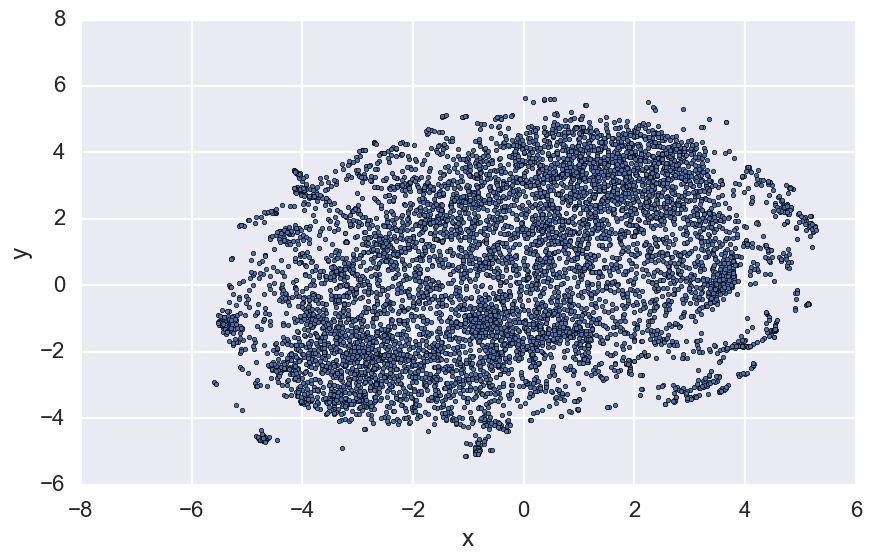

In [209]:
# Display the layout of all of the points.
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(10, 6))

In [210]:
def plot_region(x_bounds, y_bounds):
    '''Plot a limited region with points annotated by the word they represent.'''
    slice = points[(x_bounds[0] <= points.x) & (points.x <= x_bounds[1]) & 
                   (y_bounds[0] <= points.y) & (points.y <= y_bounds[1])]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 6))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [223]:
# Find the coordinates for Alice - Alice's Adventures in Wonderland
points[points.word == 'Alice']

,word,x,y
2460,Alice,-3.051084,0.351168


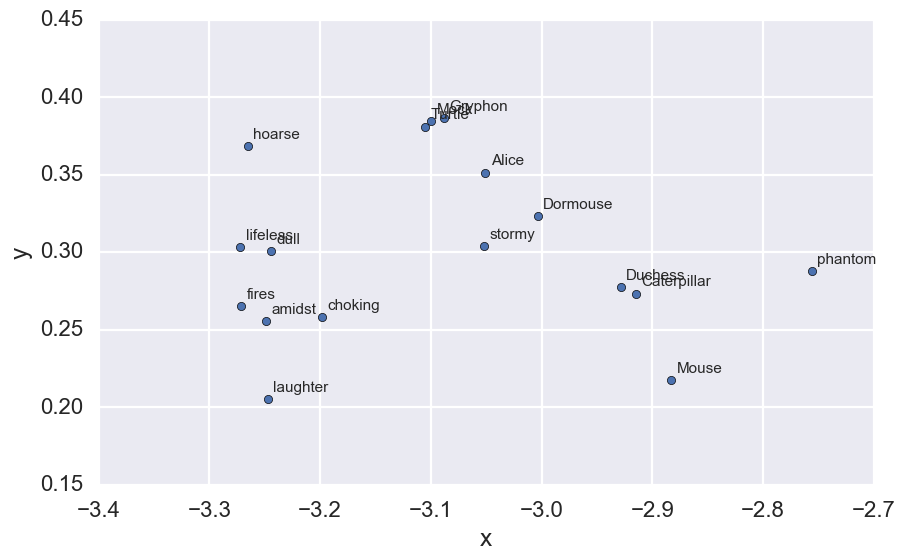

In [232]:
plot_region(x_bounds=(-3.3, -2.7), y_bounds=(0.2, 0.4))

We can see that a number of characters from Alice's Adventures in Wonderland are grouped together.

In [235]:
# Find the coordinates for (Tom) Sawyer - The Adventures of Tom Sawyer
points[points.word == 'Sawyer']

,word,x,y
5211,Sawyer,-4.007866,0.951503


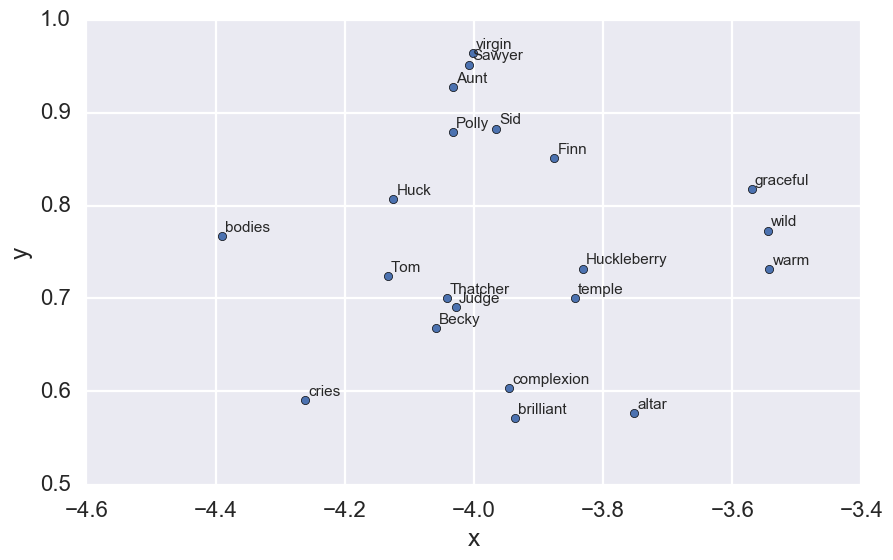

In [237]:
plot_region(x_bounds=(-4.5, -3.5), y_bounds=(0.5, 1))

Similarly, both characters and their first and last names are grouped together: Becky Thatcher, Judge Thatcher, Huck/Hucklebrry Finn, Tom Sawyer, Sid Sawyer, and Aunt Polly.

Now let's find the most similar words for each given word.

In [408]:
books2vec.most_similar("monster") 

[('fiend', 0.8998374938964844),
 ('therein', 0.8819494247436523),
 ('thirst', 0.8800548315048218),
 ('madman', 0.8657408952713013),
 ('depths', 0.8623664379119873),
 ('burden', 0.8616245985031128),
 ('hateful', 0.8606204390525818),
 ('bounds', 0.8604696989059448),
 ('wounds', 0.8603576421737671),
 ('struggle', 0.8582006096839905)]

In [240]:
books2vec.most_similar("Sherlock")

[('Holmes', 0.7802868485450745),
 ('Lestrade', 0.7051103711128235),
 ('Baker', 0.6481215953826904),
 ('Windibank', 0.6189417839050293),
 ('Burke', 0.5836223363876343),
 ('envelope', 0.5835006237030029),
 ('Menton', 0.5819653272628784),
 ('respectfully', 0.5793308615684509),
 ('Samsa', 0.5759549140930176),
 ('editor', 0.5759009122848511)]

In [241]:
books2vec.most_similar("dog")

[('rat', 0.6749559044837952),
 ('cat', 0.6618028879165649),
 ('ass', 0.6469713449478149),
 ('wolf', 0.629012942314148),
 ('chicken', 0.623235821723938),
 ('fool', 0.6210979223251343),
 ('sheep', 0.6137685775756836),
 ('rip', 0.6096508502960205),
 ('horse', 0.6086182594299316),
 ('hare', 0.6037286520004272)]

In [246]:
books2vec.most_similar("frightened")

[('shocked', 0.7078791260719299),
 ('startled', 0.6963750123977661),
 ('vexed', 0.693805456161499),
 ('amazed', 0.6904046535491943),
 ('bewildered', 0.6779297590255737),
 ('terrified', 0.6772314310073853),
 ('distressed', 0.6757149696350098),
 ('terribly', 0.6741852760314941),
 ('overpowered', 0.6624029874801636),
 ('annoyed', 0.6581168174743652)]

For the most part, the similar words seem to match the given one.

In [272]:
def nearest_similarity_cosmul(start1, end1, start2):
    '''Find the word that completes the relationship.'''
    similarities = books2vec.most_similar_cosmul(
        positive=[start1, start2],
        negative=[end1])
    end2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return end2

In [315]:
nearest_similarity_cosmul("Sherlock", "Holmes", "Huck")
nearest_similarity_cosmul("Pip", "Havisham", "Alice")
nearest_similarity_cosmul("good", "evil", "happy")

Sherlock is related to Holmes, as Huck is related to Finn
Pip is related to Havisham, as Alice is related to Caterpillar
good is related to evil, as happy is related to rich


'rich'

Again, we can see expected relationships, such as: 
- first/last names: Sherlock Holmes - Huck Finn
- Character Relationships: Pip Pirrip + Miss Havisham - Alice + Caterpillar

As I was experimenting with different words, I found the third relationship. It's surprised me and I find it rather interesting, so I want to share it with you all.

# Doc2Vec

In [339]:
# Read and tag each book into book_corpus
book_corpus = []
for book_filename in book_filenames:
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        book_corpus.append(
            gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess( # Clean the text with simple_preprocess
                    book_file.read()),
                    ["{}".format(book_filename)])) # Tag each book with its filename

In [410]:
# We can expand the vocabulary by setting the min_count to 3.
# Larger values for iter should improve the model's accuracy.
model = gensim.models.doc2vec.Doc2Vec(size = 300, 
                                      min_count = 3, 
                                      iter = 100)

In [411]:
model.build_vocab(book_corpus)
print("model's vocabulary length:", len(model.vocab))

model's vocabulary length: 21891


In [421]:
model.train(book_corpus)

19661021

Below we will find the most similar books compared to the given one.

In [422]:
model.docvecs.most_similar("The_Adventures_of_Tom_Sawyer_by_Mark_Twain.rtf")

[('Adventures_of_Huckleberry_Finn_by_Mark_Twain.rtf', 0.4656756520271301),
 ('The_Prince_by_Nicolo_Machiavelli.rtf', 0.45554542541503906),
 ('The_Yellow_Wallpaper_by_Charlotte_Perkins_Gilman.rtf', 0.40779173374176025),
 ('Grimms_Fairy_Tales_by_The_Brothers_Grimm.rtf', 0.40633681416511536),
 ('Frankenstein_by_Mary_Shelley.rtf', 0.3978717625141144),
 ('Ulysses_by_James_Joyce.rtf', 0.39747077226638794),
 ('Emma_by_Jane_Austen.rtf', 0.39602717757225037),
 ('The_Picture_of_Dorian_Gray_by_Oscar_Wilde.rtf', 0.39594709873199463),
 ('Pride_and_Prejudice_by_Jane_Austen.rtf', 0.3944284915924072),
 ('Alices_Adventures_in_Wonderland_by_Lewis_Carroll.rtf', 0.38351374864578247)]

In [423]:
model.docvecs.most_similar("The_Adventures_of_Sherlock_Holmes_by_Arthur_Conan_Doyle.rtf")

[('The_Prince_by_Nicolo_Machiavelli.rtf', 0.44073811173439026),
 ('A_Dolls_House_by_Henrik_Ibsen.rtf', 0.4378156363964081),
 ('Frankenstein_by_Mary_Shelley.rtf', 0.4135681986808777),
 ('The_Yellow_Wallpaper_by_Charlotte_Perkins_Gilman.rtf', 0.4075046181678772),
 ('Dracula_by_Bram_Stoker.rtf', 0.4019283950328827),
 ('The_Importance_of_Being_Earnest_by_Oscar_Wilde.rtf', 0.3885539770126343),
 ('The_Picture_of_Dorian_Gray_by_Oscar_Wilde.rtf', 0.3805466592311859),
 ('The_Romance_of_Lust_by_Anonymous.rtf', 0.3700585961341858),
 ('Metamorphosis_by_Franz_Kafka.rtf', 0.366908997297287),
 ('Great_Expectations_by_Charles_Dickens.rtf', 0.3642672598361969)]

In [424]:
model.docvecs.most_similar("The_Prince_by_Nicolo_Machiavelli.rtf")

[('Frankenstein_by_Mary_Shelley.rtf', 0.515625),
 ('Metamorphosis_by_Franz_Kafka.rtf', 0.4940919578075409),
 ('Grimms_Fairy_Tales_by_The_Brothers_Grimm.rtf', 0.48193156719207764),
 ('The_Count_of_Monte_Cristo_by_Alexandre_Dumas.rtf', 0.47552549839019775),
 ('A_Dolls_House_by_Henrik_Ibsen.rtf', 0.46179383993148804),
 ('The_Adventures_of_Tom_Sawyer_by_Mark_Twain.rtf', 0.45554542541503906),
 ('Adventures_of_Huckleberry_Finn_by_Mark_Twain.rtf', 0.45545029640197754),
 ('Ulysses_by_James_Joyce.rtf', 0.4460642635822296),
 ('Dracula_by_Bram_Stoker.rtf', 0.4440779685974121),
 ('The_Yellow_Wallpaper_by_Charlotte_Perkins_Gilman.rtf', 0.44344234466552734)]

In [425]:
# Find the most similar book for each book
for book in book_filenames:
    most_similar = model.docvecs.most_similar(book)[0][0]
    print("{} - {}".format(book, most_similar))

A_Dolls_House_by_Henrik_Ibsen.rtf - Metamorphosis_by_Franz_Kafka.rtf
A_Tale_of_Two_Cities_by_Charles_Dickens.rtf - Alices_Adventures_in_Wonderland_by_Lewis_Carroll.rtf
Adventures_of_Huckleberry_Finn_by_Mark_Twain.rtf - The_Yellow_Wallpaper_by_Charlotte_Perkins_Gilman.rtf
Alices_Adventures_in_Wonderland_by_Lewis_Carroll.rtf - Grimms_Fairy_Tales_by_The_Brothers_Grimm.rtf
Dracula_by_Bram_Stoker.rtf - The_Prince_by_Nicolo_Machiavelli.rtf
Emma_by_Jane_Austen.rtf - Pride_and_Prejudice_by_Jane_Austen.rtf
Frankenstein_by_Mary_Shelley.rtf - The_Prince_by_Nicolo_Machiavelli.rtf
Great_Expectations_by_Charles_Dickens.rtf - Adventures_of_Huckleberry_Finn_by_Mark_Twain.rtf
Grimms_Fairy_Tales_by_The_Brothers_Grimm.rtf - Alices_Adventures_in_Wonderland_by_Lewis_Carroll.rtf
Metamorphosis_by_Franz_Kafka.rtf - A_Dolls_House_by_Henrik_Ibsen.rtf
Pride_and_Prejudice_by_Jane_Austen.rtf - Emma_by_Jane_Austen.rtf
The_Adventures_of_Sherlock_Holmes_by_Arthur_Conan_Doyle.rtf - The_Prince_by_Nicolo_Machiavelli.rtf

I feel quite good about the results that we have here. Books by the same author are often the most similar: Adventures of Huckleberry Finn - The Adventures of Tom Sawyer; Emma - Pride and Prejudice, however The Importance of Being Earnest - The Picture of Dorian Gray did not match up both ways.

The Prince is the most similar book for four others. An interesting idea for another project would be to try and find what makes this book able to match other books so well.

# Summary

I hope that you will agree with me and say that this project is a success. By using Word2Vec we were able to draw comparisons within and between books, and by using Doc2Vec we could compare the overall similarity of books. Some of the examples that I used were 'cherry-picked.' If you try out this project and `nearest_similarity_cosmul()` doesn't always work exactly as you expected, that happened to me as well. Nonetheless, the fact that it does work and with multiple examples is very positive.